In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
def get_data():
    file = "C:/Users/aprodea/work/metrics-tax-compare/merged/merged_filledna.csv"
    data = pd.read_csv(file, sep=';')
    return data

merged_data = get_data()
merged_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0
...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,17.0,4.0


In [3]:
list_columns = merged_data.columns.tolist()
list_columns.remove('Method')
list_columns

['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']

In [4]:
scaled_data = merged_data.copy()

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
    min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.150538,0.042254,0.000000,0.020408,0.1,0.000000,0.025641,0.051282,0.000115
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.010753,0.014085,0.000000,0.000000,0.0,0.000000,0.000000,0.025641,0.000115
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.021505,0.014085,0.000000,0.000000,0.0,0.000000,0.012821,0.025641,0.000115
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.021505,0.014085,0.000000,0.000000,0.0,0.116279,0.000000,0.025641,0.106956
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.021505,0.014085,0.000000,0.000000,0.0,0.093023,0.000000,0.025641,0.068034
...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.086022,0.014085,0.071429,0.000000,0.0,0.023256,0.038462,0.102564,0.000115
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.010753,0.042254,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.010753,0.084507,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.021505,0.014085,0.071429,0.000000,0.0,0.000000,0.012821,0.435897,0.000115


In [5]:
scaled_data[list_columns]

,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,0.150538,0.042254,0.000000,0.020408,0.1,0.000000,0.025641,0.051282,0.000115
1,0.010753,0.014085,0.000000,0.000000,0.0,0.000000,0.000000,0.025641,0.000115
2,0.021505,0.014085,0.000000,0.000000,0.0,0.000000,0.012821,0.025641,0.000115
3,0.021505,0.014085,0.000000,0.000000,0.0,0.116279,0.000000,0.025641,0.106956
4,0.021505,0.014085,0.000000,0.000000,0.0,0.093023,0.000000,0.025641,0.068034
...,...,...,...,...,...,...,...,...,...
799,0.086022,0.014085,0.071429,0.000000,0.0,0.023256,0.038462,0.102564,0.000115
800,0.010753,0.042254,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231
801,0.010753,0.084507,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231
802,0.021505,0.014085,0.071429,0.000000,0.0,0.000000,0.012821,0.435897,0.000115


In [82]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v
# scaled_data[list_columns].corr(method=histogram_intersection)
scaled_data[list_columns].corr(method='pearson')

,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
LOC,1.000000,0.818046,0.202876,0.735513,0.477668,-0.009790,0.683218,0.521519,-0.058513
CC,0.818046,1.000000,0.097643,0.676817,0.496175,0.012628,0.671144,0.539215,-0.038773
NP,0.202876,0.097643,1.000000,0.133015,0.042570,-0.018148,0.037268,0.076803,0.066878
NV,0.735513,0.676817,0.133015,1.000000,0.644881,0.044936,0.487904,0.448622,-0.014726
NEST,0.477668,0.496175,0.042570,0.644881,1.000000,-0.013867,0.355599,0.268070,-0.035725
Ca,-0.009790,0.012628,-0.018148,0.044936,-0.013867,1.000000,-0.023237,0.024080,0.034897
Ce,0.683218,0.671144,0.037268,0.487904,0.355599,-0.023237,1.000000,0.572186,-0.064640
NChg,0.521519,0.539215,0.076803,0.448622,0.268070,0.024080,0.572186,1.000000,-0.027705
NCall,-0.058513,-0.038773,0.066878,-0.014726,-0.035725,0.034897,-0.064640,-0.027705,1.000000


winner:  ('diag', 8)


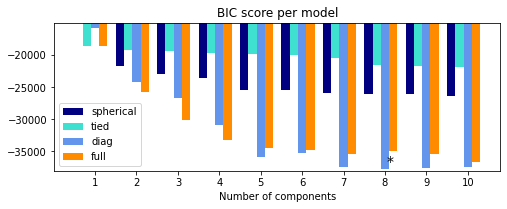

In [77]:
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = scaled_data.shape[0]
X = scaled_data[list_columns].to_numpy()

lowest_bic = np.infty
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
win='',0
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            win = cv_type, n_components

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

print("winner: ", win)

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

In [53]:
gmm = best_gmm
gmm.fit(scaled_data[list_columns])

GaussianMixture(n_components=3)

In [35]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(scaled_data[list_columns])

GaussianMixture(n_components=3)

In [54]:
gmm.n_iter_

15

In [55]:
# True when convergence was reached in fit(), False otherwise.
gmm.converged_

True

In [56]:
# Lower bound value on the log-likelihood (of the training data with respect to the model) of the best fit of EM.
gmm.lower_bound_

19.090823146339844

In [57]:
# The weights of each mixture components.
gmm.weights_

array([0.61402143, 0.11842338, 0.2675552 ])

In [58]:
groups = gmm.predict(scaled_data[list_columns])

In [59]:
scaled_data['CLevel'] = groups
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel,CLevelLbl
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.150538,0.042254,0.000000,0.020408,0.1,0.000000,0.025641,0.051282,0.000115,2,regular
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.010753,0.014085,0.000000,0.000000,0.0,0.000000,0.000000,0.025641,0.000115,0,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.021505,0.014085,0.000000,0.000000,0.0,0.000000,0.012821,0.025641,0.000115,0,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.021505,0.014085,0.000000,0.000000,0.0,0.116279,0.000000,0.025641,0.106956,1,low
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.021505,0.014085,0.000000,0.000000,0.0,0.093023,0.000000,0.025641,0.068034,1,low
...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.086022,0.014085,0.071429,0.000000,0.0,0.023256,0.038462,0.102564,0.000115,2,regular
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.010753,0.042254,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231,0,regular
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.010753,0.084507,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231,2,regular
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.021505,0.014085,0.071429,0.000000,0.0,0.000000,0.012821,0.435897,0.000115,2,high


In [60]:
first = scaled_data[scaled_data['CLevel'] == 0]
second = scaled_data[scaled_data['CLevel'] == 1] 
thrid = scaled_data[scaled_data['CLevel'] == 2]

print(len(first), len(second), len(thrid))

496 95 213


In [61]:
f_means = first[list_columns].mean(axis = 0)
f_means.mean()

0.03240771110957308

In [62]:
s_means = second[list_columns].mean(axis = 0)
s_means.mean()

0.056799491349172046

In [63]:
t_means = thrid[list_columns].mean(axis = 0)
t_means.mean()

0.10225821844044904

In [64]:
def to_string_label(value):
    if value == 0:
        return "low"
    elif value == 1:
        return "regular"
    if value == 2:
        return "high"
scaled_data['CLevelLbl'] = scaled_data['CLevel'].apply(to_string_label)
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel,CLevelLbl
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.150538,0.042254,0.000000,0.020408,0.1,0.000000,0.025641,0.051282,0.000115,2,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.010753,0.014085,0.000000,0.000000,0.0,0.000000,0.000000,0.025641,0.000115,0,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.021505,0.014085,0.000000,0.000000,0.0,0.000000,0.012821,0.025641,0.000115,0,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.021505,0.014085,0.000000,0.000000,0.0,0.116279,0.000000,0.025641,0.106956,1,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.021505,0.014085,0.000000,0.000000,0.0,0.093023,0.000000,0.025641,0.068034,1,regular
...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.086022,0.014085,0.071429,0.000000,0.0,0.023256,0.038462,0.102564,0.000115,2,high
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.010753,0.042254,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231,0,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.010753,0.084507,0.142857,0.000000,0.1,0.023256,0.025641,0.025641,0.000231,2,high
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.021505,0.014085,0.071429,0.000000,0.0,0.000000,0.012821,0.435897,0.000115,2,high


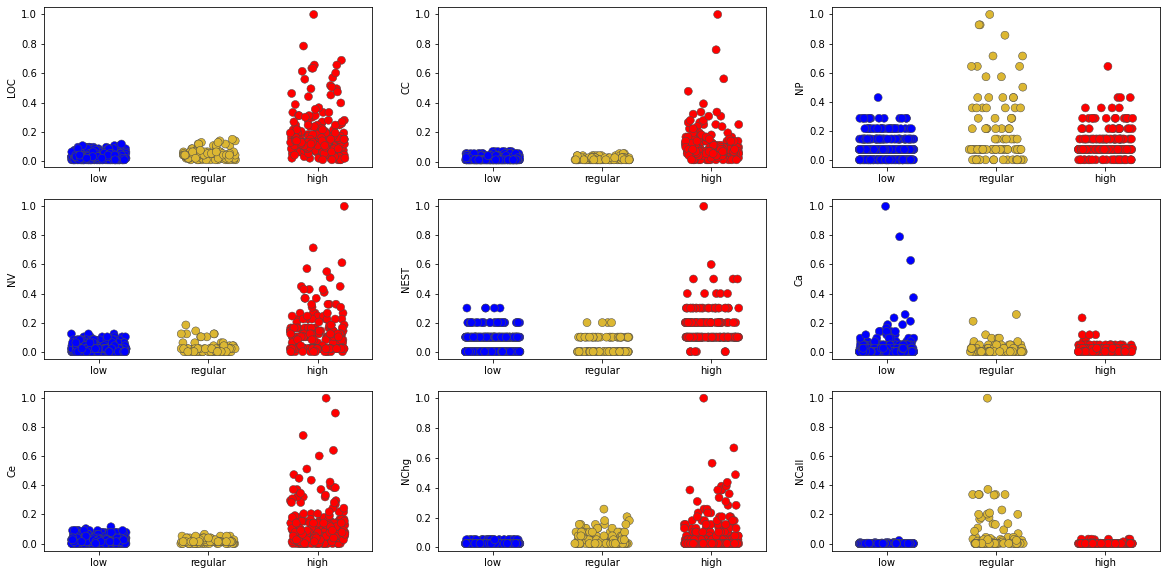

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax = axes.flatten()
for i in range(len(list_columns)):
    col_name = list_columns[i]
    sns.stripplot(data=scaled_data, x='CLevelLbl', y=col_name, 
#                   hue='CLevelLbl', 
                  palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
                  jitter=0.25, size=8, ax=ax[i], linewidth=.5,
                  order=["low", "regular", "high"])
    ax[i].set_ylabel(col_name)
    ax[i].set_xlabel("")

plt.show()

In [66]:
df = scaled_data.copy()
list_columns = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']
# df = df.stack()
df = pd.melt(df, id_vars=['Method', 'CLevelLbl'], value_vars=list_columns)
df

,Method,CLevelLbl,variable,value
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),high,LOC,0.150538
1,GES_GRT.GES_GRTCoreModule.Initialize(),low,LOC,0.010753
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),low,LOC,0.021505
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,regular,LOC,0.021505
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),regular,LOC,0.021505
...,...,...,...,...
7231,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,high,NCall,0.000115
7232,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,low,NCall,0.000231
7233,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,high,NCall,0.000231
7234,GES_GRT.Web.App.Startup.AppNavigationProvider....,high,NCall,0.000115


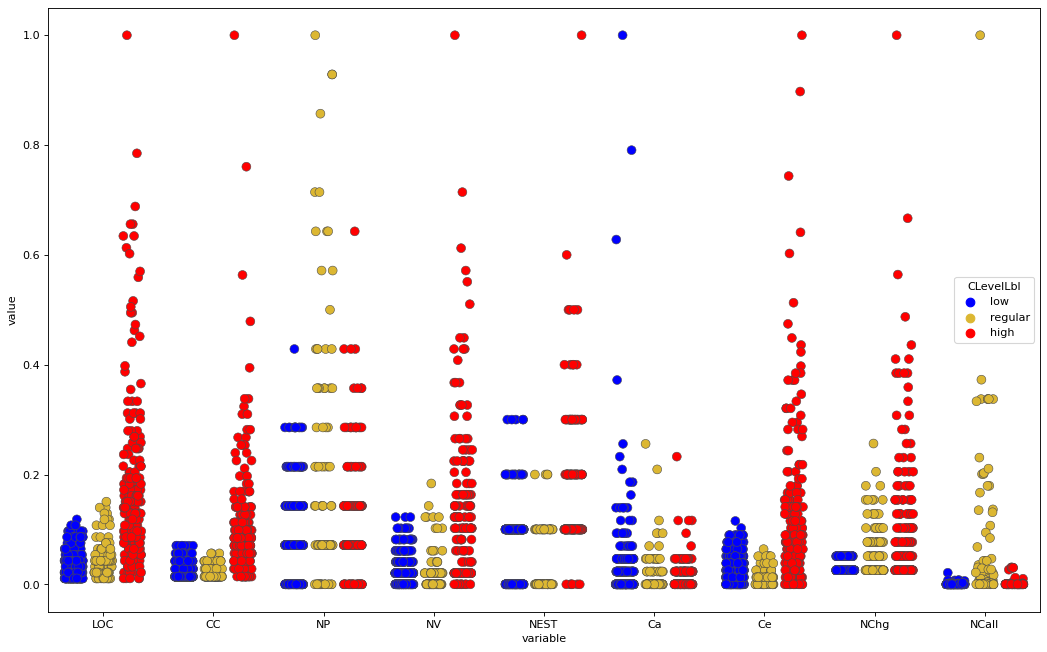

In [67]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(data=df, x='variable', y='value', hue='CLevelLbl',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)

plt.show()

In [68]:
merged_data['CLevel'] = groups
merged_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,2
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,0
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,0
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,1
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,1
...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,2
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,0
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,2
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,17.0,4.0,2


In [69]:
def to_string_label(value):
    if value == 0:
        return "low"
    elif value == 1:
        return "regular"
    if value == 2:
        return "high"
merged_data['CLevel'] = merged_data['CLevel'].apply(to_string_label)
merged_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,regular
...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,high
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,high
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,17.0,4.0,high


In [70]:
low_critical = len(merged_data[merged_data['CLevel'] == "low"])
regular_critical = len(merged_data[merged_data['CLevel'] == "regular"]) 
high_critical = len(merged_data[merged_data['CLevel'] == "high"])

print(low_critical, regular_critical, high_critical)

496 95 213


In [71]:
high_critical_data = merged_data[merged_data['CLevel'] == "high"]
high_critical_data.to_csv("C:/Users/aprodea/work/metrics-tax-compare/merged/high_critical_data_em_gmm.csv", sep=';', index=False)

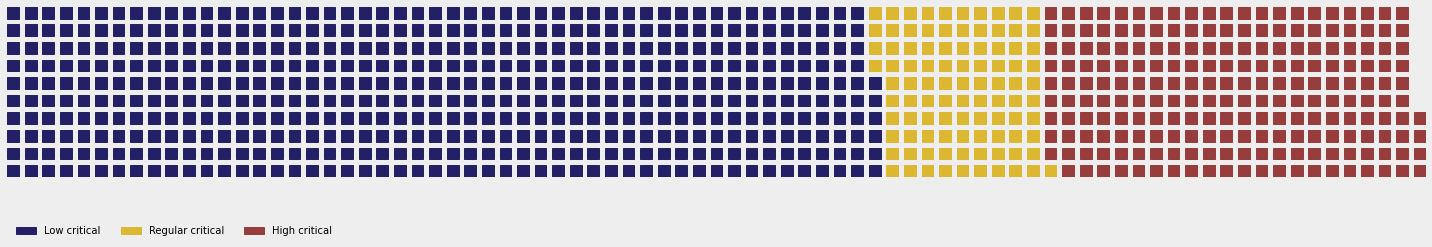

In [72]:
from pywaffle import Waffle

data = {'Low critical': low_critical, 'Regular critical': regular_critical, 'High critical': high_critical}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#232066", "#DCB732", "#983D3D"),
    labels=['Low critical', 'Regular critical', 'High critical'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    interval_ratio_x=0.5,
    interval_ratio_y=0.5,
    figsize=(20,10)
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.show()

In [73]:
data_class = merged_data.copy()

def split_at_last_point(s):
    idx = s.rfind('.')
    return s[:idx], s[idx+1:]
def split_method_name(value):
    parent, method_name = split_at_last_point(value)
    parent, class_name = split_at_last_point(parent)
    return pd.Series([parent, class_name, method_name])

data_class[['Parent_class', 'Class', 'Method']] = data_class['Method'].apply(split_method_name)
data_class

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel,Parent_class,Class
0,PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,high,GES_GRT,GES_GRTCoreModule
1,Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,GES_GRT,GES_GRTCoreModule
2,PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,GES_GRT,GES_GRTCoreModule
3,GES_GRTDomainServiceBase(),2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,regular,GES_GRT,GES_GRTDomainServiceBase
4,GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,regular,GES_GRT,GES_GRTServiceBase
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,RegisterBundles(BundleCollection),8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,high,GES_GRT.Web.App.Startup,AppBundleConfig
800,"AddAppCssLibs(BundleCollection,Boolean)",1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,GES_GRT.Web.App.Startup,AppBundleConfig
801,"AddAppMetronicCss(BundleCollection,Boolean)",1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,high,GES_GRT.Web.App.Startup,AppBundleConfig
802,SetNavigation(INavigationProviderContext),2.0,1.0,1,0.0,0.0,0,1,17.0,4.0,high,GES_GRT.Web.App.Startup,AppNavigationProvider


In [74]:
import plotly.express as px

config = dict({'scrollZoom': True})

fig = px.treemap(data_class, path=['Parent_class', 'Class', 'Method'], values='LOC', color='CLevel',
                  color_discrete_map={'(?)':'black', 'low':'blue', 'regular':'yellow', 'high':'red'})
fig.show(config=config)